Based on a post @ [Towards Data Science](https://towardsdatascience.com/a-complete-guide-to-principal-component-analysis-pca-in-machine-learning-664f34fc3e5a).

**Principal Component Analysis (PCA)**: "widely used technique for dimensionality reduction of the large data set".

#### Steps:

1. "Standardize the data. (with mean =0 and variance = 1)";
2. "Compute the Covariance matrix of dimensions";
3. "Obtain the Eigenvectors and Eigenvalues from the covariance matrix (we can also use correlation matrix or even Single value decomposition, however in this post will focus on covariance matrix)";
4. "Sort eigenvalues in descending order and choose the top $k$ Eigenvectors that correspond to the $k$ largest eigenvalues ($k$ will become the number of dimensions of the new feature subspace $k \leq d$, $d$ is the number of original dimensions)";
5. "Construct the projection matrix $W$ from the selected $k$ Eigenvectors";
6. "Transform the original data set $X$ via $W$ to obtain the new $k$-dimensional feature subspace $Y$."


Importing required libraries:

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 
%matplotlib inline

Importing data set:

In [3]:
df = pd.read_csv(filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                 header=None, sep=',')

In [7]:
df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

In [8]:
print(df.isnull().values.any())

False


In [9]:
df.dropna(how="all", inplace=True)

In [10]:
df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Separating the target columns:

In [11]:
X = df.iloc[:,0:4].values 
y = df.iloc[:,4].values

### 1. Standardization

> "The reason why standardization is very much needed before performing PCA is that PCA is very sensitive to variances. Meaning, if there are large differences between the scales (ranges) of the features, then those with larger scales will dominate over those with the small scales."

Formula:

$$
\tilde x_i = \displaystyle\frac{x_i - \mu_X}{\sigma_X}
$$

where:
- $\tilde x_i$: standardized value of $x_i$.
- $\mu_X = \displaystyle\frac{1}{N}\sum_{i} x_i$: mean.
- $\sigma_X = \sqrt{\displaystyle\frac{1}{N}\sum_{i} (x_i - \mu_X)^2}$: standard deviation.

We will use the *scikit-learn*'s `StandardScaler()`. Doc [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [14]:
X_std = StandardScaler().fit_transform(X)

### 2. Eigendecomposition

> "The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” of a PCA:"

>> "The Eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude."

>> "In other words, the eigenvalues explain the variance of the data along the new feature axes. It means the corresponding eigenvalue tells us that how much variance is included in that new transformed feature."

>> "To get eigenvalues and Eigenvectors we need to compute the covariance matrix."

#### 2.1 Covariance Matrix

> "The classic approach to PCA is to perform the Eigen decomposition on the covariance matrix $\sigma$, which is a $d \times d$ matrix where each element represents the covariance between two features. Note, $d$ is the number of original dimensions of the data set."

Manually:

~~~
mean_vec = np.mean(X_std, axis=0) 
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1) 
~~~

Using `numpy.cov()`:

~~~
cov_mat= np.cov(X_std, rowvar=False)
~~~

#### 2.2 Eigenvectors and Eigenvalues computation (from the Covariance Matrix)

We will use `numpy.linalg.eig()`. Doc [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html).

More [here](https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/) and [here](https://pathmind.com/wiki/eigenvector).

In [19]:
cov_mat = np.cov(X_std.T) 
eig_vals, eig_vecs = np.linalg.eig(cov_mat) 
print('Eigenvectors \n%s' %eig_vecs) 
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


#### 2.3 Eigenvectors verification

> "As we know that the sum of the square of each value in an Eigenvector is 1. So let’s see if it holds which mean we have computed Eigenvectors correctly."

More on `numpy.testing.assert_array_almost_equal()` [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.testing.assert_array_almost_equal.html).

In [30]:
sq_eig=[]

for i in eig_vecs:
    sq_eig.append(i**2)

print(sum(sq_eig)) 

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

[1. 1. 1. 1.]


## 3. Selecting The Principal Components

> "The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes."

> "However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1."

**"So now the question comes that how to select the new set of Principal components. The rule behind is that we sort the Eigenvalues in descending order and then choose the top $k$ features concerning top $k$ Eigenvalues."**

> "he idea here is that by choosing top k we have decided that the variance which corresponds to those k feature space is enough to describe the data set. And by losing the remaining variance of those not selected features, won’t cost the accuracy much or we are OK to loose that much accuracy that costs because of neglected variance."

#### 3.1 Sorting eigenvalues

> "The Eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped."

> "To do so, the common approach is to rank the eigenvalues from highest to lowest to choose the top $k$ Eigenvectors."


In [37]:
#Make a list of (eigenvalue, eigenvector) tuples 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))] 
print(type(eig_pairs))

#Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()
print("\n",eig_pairs) 

#Visually confirm that the list is correctly sorted by decreasing eigenvalues 
print('\nEigenvalues in descending order:') 

for i in eig_pairs: 
    print(i[0])


<class 'list'>

 [(2.9303537755893165, array([ 0.52237162, -0.26335492,  0.58125401,  0.56561105])), (0.9274036215173417, array([-0.37231836, -0.92555649, -0.02109478, -0.06541577])), (0.1483422264816399, array([-0.72101681,  0.24203288,  0.14089226,  0.6338014 ])), (0.02074601399559571, array([ 0.26199559, -0.12413481, -0.80115427,  0.52354627]))]

Eigenvalues in descending order:
2.9303537755893165
0.9274036215173417
0.1483422264816399
0.02074601399559571


#### 3.2 Explained Variance

> "After sorting the eigenpairs, the next question is '*how many principal components are we going to choose for our new feature subspace*?'"

> "A useful measure is the so-called 'explained variance', which can be calculated from the eigenvalues."

> "The explained variance tells us how much information (variance) can be attributed to each of the principal components."


In [39]:
tot = sum(eig_vals) 
print("\n",tot) 

var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
print("\n\n1. Variance Explained\n",var_exp) 

cum_var_exp = np.cumsum(var_exp)

print("\n\n2. Cumulative Variance Explained\n",cum_var_exp)
print("\n\n3. Percentage of variance the first two principal components each contain\n ",var_exp[0:2]) 
print("\n\n4. Percentage of variance the first two principal components together contain\n",sum(var_exp[0:2]))


 4.026845637583894


1. Variance Explained
 [72.77045209380134, 23.030523267680643, 3.683831957627389, 0.5151926808906266]


2. Cumulative Variance Explained
 [ 72.77045209  95.80097536  99.48480732 100.        ]


3. Percentage of variance the first two principal components each contain
  [72.77045209380134, 23.030523267680643]


4. Percentage of variance the first two principal components together contain
 95.80097536148199


### 4. Construct the projection matrix $W$ from the selected $k$ eigenvectors

> "Projection matrix will be used to transform the Iris data onto the new feature subspace or we say newly transformed data set with reduced dimensions."

> "It is a matrix of our concatenated top $k$ Eigenvectors."

"**Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the 'top 2' Eigenvectors with the highest Eigenvalues to construct our $d \times k$-dimensional Eigenvector matrix $W$.**"

We will use `numpy.hstack()`. Doc [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html).

In [40]:
print(eig_pairs[0][1]) 
print(eig_pairs[1][1]) 
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1))) 
#hstack: Stacks arrays in sequence horizontally (column wise)
print('\nMatrix W:\n', matrix_w)

[ 0.52237162 -0.26335492  0.58125401  0.56561105]
[-0.37231836 -0.92555649 -0.02109478 -0.06541577]
Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


### 5. Projection Onto the New Feature Space

> "In this last step, we will use the $4 \times 2$-dimensional projection matrix $W$ to transform our samples onto the new subspace via the equation $Y=X \times W$, where the output matrix $Y$ will be a $150 \times 2$ matrix of our transformed samples."


In [42]:
Y = X_std.dot(matrix_w) 
principalDf = pd.DataFrame(data = Y , columns = ['principal component 1', 'principal component 2']) 
principalDf.head(10)

,principal component 1,principal component 2
0,-2.264542,-0.505704
1,-2.086426,0.655405
2,-2.367950,0.318477
3,-2.304197,0.575368
4,-2.388777,-0.674767
5,-2.070537,-1.518549
6,-2.445711,-0.074563
7,-2.233842,-0.247614
8,-2.341958,1.095146
9,-2.188676,0.448629


> "Now let’s combine the target class variable which we separated in the very beginning."

In [43]:
finalDf = pd.concat([principalDf,pd.DataFrame(y,columns = ['species'])], axis = 1) 
finalDf.head(10)

,principal component 1,principal component 2,species
0,-2.264542,-0.505704,Iris-setosa
1,-2.086426,0.655405,Iris-setosa
2,-2.367950,0.318477,Iris-setosa
3,-2.304197,0.575368,Iris-setosa
4,-2.388777,-0.674767,Iris-setosa
5,-2.070537,-1.518549,Iris-setosa
6,-2.445711,-0.074563,Iris-setosa
7,-2.233842,-0.247614,Iris-setosa
8,-2.341958,1.095146,Iris-setosa
9,-2.188676,0.448629,Iris-setosa


### Visualize 2D Projection

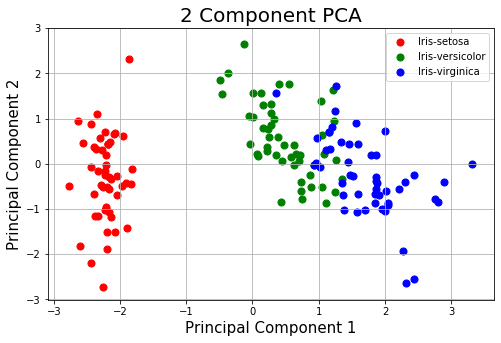

In [44]:
fig = plt.figure(figsize = (8,5)) 
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20) 

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b'] 

for target, color in zip(targets,colors): 
    indicesToKeep = finalDf['species'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = color , s = 50)

ax.legend(targets)
ax.grid()

plt.show()

### Use of Python Libraries to directly compute Principal Components

In [45]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=2)

> "Here we can also give the percentage as a paramter to the PCA function as pca = PCA(.95). .95 means that we want to include 95% of the variance. Hence PCA will return the no of components which describe 95% of the variance. However we know from above computation that 2 components are enough so we have passed the 2 components."

In [48]:
principalComponents = pca.fit_transform(X_std) 
principalDf = pd.DataFrame(data = principalComponents ,
                           columns = ['principal component 1', 'principal component 2'])

In [49]:
principalDf.head(10)

,principal component 1,principal component 2
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767
5,-2.070537,1.518549
6,-2.445711,0.074563
7,-2.233842,0.247614
8,-2.341958,-1.095146
9,-2.188676,-0.448629


In [50]:
finalDf = pd.concat([principalDf, finalDf[['species']]], axis = 1)
finalDf.head(10)

,principal component 1,principal component 2,species
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa
5,-2.070537,1.518549,Iris-setosa
6,-2.445711,0.074563,Iris-setosa
7,-2.233842,0.247614,Iris-setosa
8,-2.341958,-1.095146,Iris-setosa
9,-2.188676,-0.448629,Iris-setosa
